In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
import matplotlib.image as mpimg
%matplotlib inline

# Morphology image processing 

In [2]:
SOBEL_X = [   
    [1, 2, 1],
    [0, 0, 0],
    [-1,-2,-1]
]

SOBEL_Y = [
    [1,0, -1],
    [2,0, -2],
    [-1,0, 1]
]
def show(image_name, img):
    print(image_name)
    imgplot = plt.imshow(img)
    cv2.imwrite(image_name + '.jpg', np.asarray(img))

def normalize_matrix(A):
    row_a_size = len(A)
    col_a_size = len(A[0]) 
    max_x = 0
    min_x = A[0][0]
    for i in range(0, row_a_size):
        max_x = max(max(A[i]), max_x)
        min_x = min(min(A[i]), min_x)
    for i in range(0, row_a_size):
        for j in range(0, col_a_size):
            A[i][j] = int(255 * ((max_x - A[i][j])/(max_x - min_x)))
    return A

def add_padding(a, n = 3):
    row_len = len(a)
    col_len = len(a[0])
    MATRIX_1 = []
    padding_len = int((n - 1)/2) 
    for i in range(0, padding_len):
        MATRIX_1.append([0]*(col_len + n - 1))
    for i in range(0, row_len):
        MATRIX_1.append([0]*padding_len + a[i] + [0]*padding_len)
    for i in range(0, padding_len):
        MATRIX_1.append([0]*(col_len + + n - 1))
    return MATRIX_1

def dilate(img_padded, B):# WHERE A IS BIGGER THAN B
    A = np.asarray(img_padded).tolist()
    B = np.asarray(B).tolist() 
    n = len(B)
    padding = int((n - 1)/2)
    row_a_size = len(A)
    col_a_size = len(A[0]) 
    MATRIX_SCANNED = []
    
    for i in range(0, row_a_size):
        MATRIX_SCANNED.append([0]*col_a_size)
    for i in range(padding, row_a_size - padding):
        for j in range(padding, col_a_size - padding):
            for k in range(0, n):
                for l in range(0, n):
                    if A[i - padding + k][j - padding + l] != 0 and B[k][l] != 0:
                        MATRIX_SCANNED[i][j] = 1
                        break
    return MATRIX_SCANNED

def compliment_A(A):
    row_a_size = len(A)
    col_a_size = len(A[0]) 
    
    MATRIX_SCANNED = []
    for i in range(0, row_a_size):
        MATRIX_SCANNED.append([0]*col_a_size)
        
    for i in range(0, row_a_size):
        for j in range(0, col_a_size):
            if A[i][j] == 0:
                MATRIX_SCANNED[i][j] = 1
    return MATRIX_SCANNED

def erode(img_padded, B):
    A = np.asarray(img_padded).tolist()
    B = np.asarray(B).tolist() 
    n = len(B)
    complement_Ac = compliment_A(A)
    erode = dilate(np.asarray(complement_Ac), B)
    erode_c = compliment_A(erode)
    return erode_c

def remove_padding(img, pad):
    n = int((pad - 1)/2)
    matrix = []
    col = len(img[0])
    row = len(img)
    c,r = col - 2*n, row - 2*n 
    for i in range(n, r):
        matrix.append(img[i][n: c])
    return matrix

def matrix_mult_rect_scan(A, B, n):# WHERE A IS BIGGER THAN B
    padding = int((n - 1)/2)
    row_a_size = len(A)
    col_a_size = len(A[0]) 
    MATRIX_SCANNED = []
    for i in range(0, row_a_size):
        MATRIX_SCANNED.append([0]*col_a_size)
    for i in range(padding, row_a_size - padding):
        for j in range(padding, col_a_size - padding):
            for k in range(0, n):
                for l in range(0, n):
                    MATRIX_SCANNED[i][j] += B[k][l]*A[i - padding + k][j - padding + l]
    return MATRIX_SCANNED

def point_clearing(points):
    p = []
    for point in points:
        if point[0] > 460 and point[0] < 500:
            print(point)
            p.append(point)
    return p

Original Image


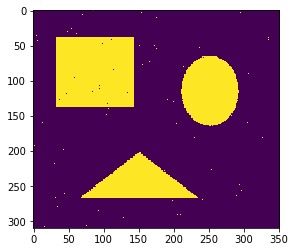

In [3]:
img = cv2.imread('original_imgs/noise.jpg', 0)
show('Original Image', img)

# Question 1a)

Opening


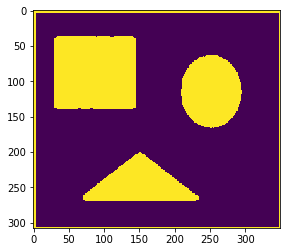

In [4]:
#### Method 1 Erosion + Dilation  ####
kernel_method_1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))

img_padding = add_padding(np.asarray(img).tolist(), kernel_method_1.shape[0])

erosion = erode(img_padding, kernel_method_1)
dilation = dilate(erosion, kernel_method_1)
dilation = dilate(dilation, kernel_method_1)

result_1 = remove_padding(dilation, kernel_method_1.shape[0])
show('Opening', result_1)

Closing


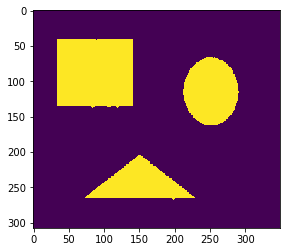

In [5]:
#### Method 2 Dilation + Erosion ####
dilation = dilate(img_padding, kernel_method_1)
erosion = erode(dilation, kernel_method_1)
erosion = erode(erosion, kernel_method_1)

result_2 = remove_padding(erosion, kernel_method_1.shape[0])
show('Closing', result_2)

# Question 1b)

Comparison


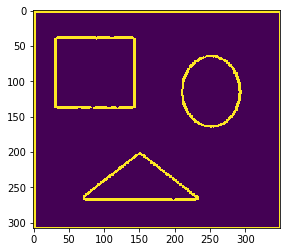

In [6]:
result_1 = np.asarray(result_1)
result_2 = np.asarray(result_2)

comparison = result_1 - result_2
show('Comparison', comparison)

# Question 1c)

res_bound1


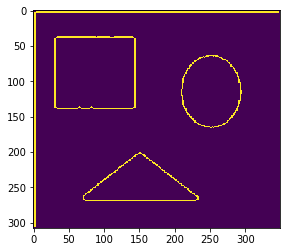

In [7]:
boundary_1 = result_1 - erode(result_1, kernel_method_1)
show('res_bound1',boundary_1)

res_bound2


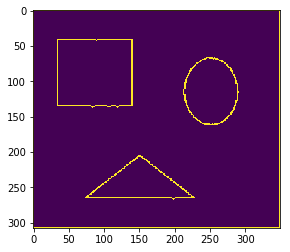

In [8]:
boundary_2 =  erode(result_2, kernel_method_1) - result_2
boundary_2 = compliment_A(compliment_A(np.asarray(boundary_2).tolist()))
show('res_bound2', boundary_2)

# Image segmentation and point detection 

# Detect the Porosity.

In [9]:
def point_detection(A, B, n, threshold, upper_threshold):# WHERE A IS BIGGER THAN B
    padding = int((n - 1)/2)
    row_a_size = len(A)
    col_a_size = len(A[0]) 
    MATRIX_SCANNED = []
    points = []
    for i in range(0, row_a_size):
        MATRIX_SCANNED.append([0]*col_a_size)
    for i in range(padding, row_a_size - padding):
        for j in range(padding, col_a_size - padding):
            for k in range(0, n):
                for l in range(0, n):
                    MATRIX_SCANNED[i][j] += B[k][l]*A[i - padding + k][j - padding + l]
            if threshold > MATRIX_SCANNED[i][j] or MATRIX_SCANNED[i][j] > upper_threshold:
                MATRIX_SCANNED[i][j] = 0
            else:
#                 print(MATRIX_SCANNED[i][j], i, j)
                MATRIX_SCANNED[i][j] = 255
                points.append((i,j))
    points = point_clearing(points)
    return np.asarray(MATRIX_SCANNED), points

(468, 243)
Multiplication
Highlighted Image


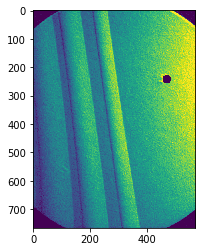

In [10]:
img_point = cv2.imread('original_imgs/turbine-blade.jpg', 0)
B = [[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]]
point_padding = add_padding(img_point.tolist())
mult, points = point_detection(point_padding, B, 3, 248, 249)
show('Multiplication', mult)
for t in points:
    cv2.circle(img_point, t, 15, (0,0,255), -1)
show('Highlighted Image', img_point)

# Segmentation by Thresholding 

In [11]:
def thresholding(img, threshold):
    r,c = len(img), len(img[0])
    for i in range(0, r):
        for j in range(0, c):
            if threshold > img[i][j]:
                img[i][j] = 0
    return img

segment


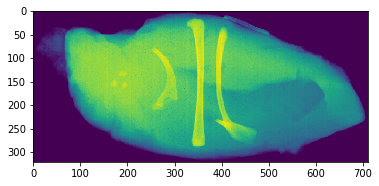

In [12]:
display_segment = cv2.imread('original_imgs/segment.jpg', 0)
img_segment = cv2.imread('original_imgs/segment.jpg', 0)
show('segment', img_segment)

In [13]:
r, c = img_segment.shape

thresholding


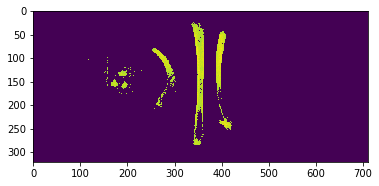

In [14]:
thresholding_img = thresholding(img_segment, 200)
show('thresholding', thresholding_img)

# Draw Rectangle

In [15]:
start_r, end_r = 0,0
start_t, end_t = 0,0

for j in range(0, c):
    for i in range(0, r):
        start_r = max(start_r, thresholding_img[i][j])
    if start_r > 0:
        start_r = j
        break
for j in range(c - 1, -1, -1):
    for i in range(0, r):
        end_r = max(end_r, thresholding_img[i][j])
    if end_r > 0:
        end_r = j
        break
for i in range(0, r):
    for j in range(0, c):
        start_t = max(start_t, thresholding_img[i][j])
    if start_t > 0:
        start_t = i
        break
for i in range(r - 1, -1, -1):
    for j in range(0, c):
        end_t = max(end_t, thresholding_img[i][j])
    if end_t > 0:
        end_t = i
        break    

Drawing Rectangle on Original


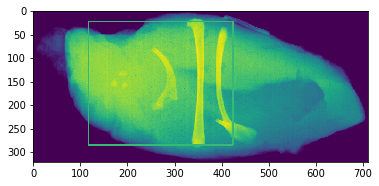

In [16]:
show('Drawing Rectangle on Original', cv2.rectangle(display_segment, (start_r, start_t),(end_r, end_t),(155,100,0),2))

Drawing Rectangle


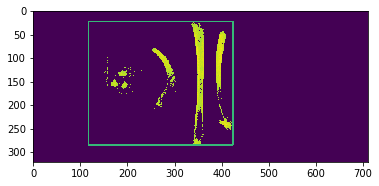

In [17]:
show('Drawing Rectangle', cv2.rectangle(img_segment, (start_r, start_t),(end_r, end_t),(155,100,0),2))

# Hough transform 

Original Gray Scale Image
(477, 666)


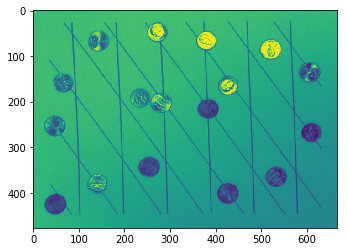

In [18]:
img_hough_original = cv2.imread('original_imgs/hough.jpg')
img_hough = cv2.imread('original_imgs/hough.jpg', 0)
img_red = img_hough_original.copy()
img_blue = img_hough_original.copy()

show('Original Gray Scale Image', img_hough)
print(img_hough.shape)

sobel_x


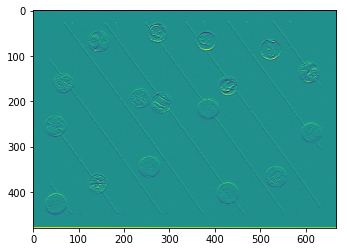

In [19]:
sobel_x = np.asarray(matrix_mult_rect_scan(add_padding(img_hough.tolist()) , SOBEL_X, 3))
show('sobel_x',sobel_x)

sobel_y


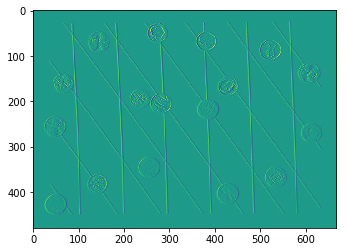

In [20]:
sobel_y = np.asarray(matrix_mult_rect_scan(add_padding(img_hough.tolist()) , SOBEL_Y, 3))
show('sobel_y',sobel_y)
img_hough = np.asarray(add_padding(img_hough.tolist()))

img_edge


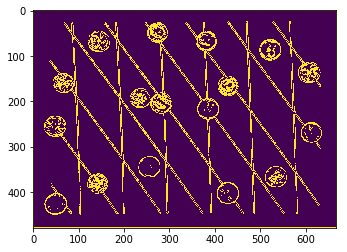

In [21]:
img_edge = np.sqrt(np.square(sobel_x) + np.square(sobel_y))
t = 100
img_edge[img_edge >= t] = 255
img_edge[img_edge < t] = 0
show('img_edge', img_edge)
img_edge = cv2.Canny(img_hough_original, 100, 200)

In [22]:
def hough_line(img, value_threshold = 75.0):
    thetas = np.deg2rad(np.arange(-90.0, 90.0))
    width, height = img.shape
    diag_len = np.ceil(np.sqrt(width * width + height * height))   # max_dist
    rhos = np.linspace(-diag_len, diag_len, diag_len * 2.0 + 1)
    
    # Cache some resuable values
    cos_t = np.cos(thetas)
    sin_t = np.sin(thetas)
    num_thetas = len(thetas)

    # Hough accumulator array of theta vs rho
    accumulator = np.zeros((int(2 * diag_len), num_thetas), dtype=np.uint64)
    are_edges = img > value_threshold
    y_idxs, x_idxs = np.nonzero(are_edges)  # (row, col) indexes to edges

    # Vote in the hough accumulator
    for i in range(len(x_idxs)):
        x = x_idxs[i]
        y = y_idxs[i]
        for t_idx in range(num_thetas):
        # Calculate rho. diag_len is added for a positive index
            rho = int(round(x * cos_t[t_idx] + y * sin_t[t_idx]) + diag_len)
            accumulator[rho, t_idx] += 1
    return accumulator, thetas, rhos

In [23]:
accumulator, thetas, rhos = hough_line(img_edge)
acc = accumulator.tolist()

/Users/pranavvij/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  """


In [24]:
idx = np.argsort(accumulator.ravel(), axis=None)[-31:]
rho = rhos[idx // accumulator.shape[1]]
theta = thetas[idx % accumulator.shape[1]]
lines = zip(rho, theta)


point_red = []
point_blue = []

for r,t in lines:
    a = np.cos(t)
    b = np.sin(t)
    x0 = a*r
    y0 = b*r
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))
    rads = abs(np.rad2deg(t))
    if rads > 10:
        try:
            cv2.line(img_blue,(x1,y1),(x2,y2),(66, 66, 244),2)
            point_blue.append((r,t))
        except:
            print(mid_x, mid_y)
    else:
        try:
            cv2.line(img_red,(x1,y1),(x2,y2),(234, 4, 73),2)
            point_red.append((r,t))
        except:
            print(mid_x, mid_y)

red line


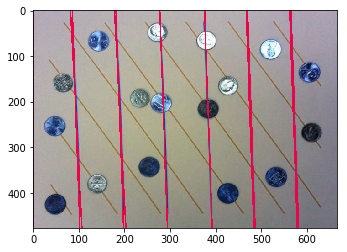

In [25]:
show('red line', img_red)

Blue line


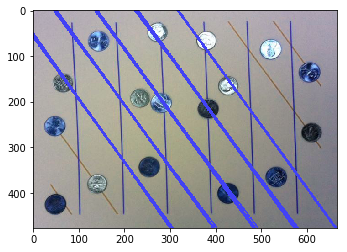

In [26]:
show('Blue line', img_blue)

In [27]:
point_red

[(178.0, -0.05235987755982989),
 (565.0, -0.03490658503988659),
 (278.0, -0.03490658503988659),
 (376.0, -0.03490658503988659),
 (86.0, -0.03490658503988659),
 (467.0, -0.03490658503988659),
 (470.0, -0.03490658503988659),
 (82.0, -0.05235987755982989),
 (182.0, -0.03490658503988659),
 (562.0, -0.03490658503988659),
 (0.0, 0.0)]

In [28]:
point_blue

[(107.0, -0.6457718232379019),
 (182.0, -0.6283185307179586),
 (177.0, -0.6457718232379019),
 (110.0, -0.6283185307179586),
 (35.0, -0.6457718232379019),
 (256.0, -0.6283185307179586),
 (40.0, -0.6283185307179586),
 (113.0, -0.6283185307179586),
 (-28.0, -0.6108652381980153),
 (185.0, -0.6283185307179586),
 (-32.0, -0.6283185307179586),
 (-35.0, -0.6283185307179586),
 (255.0, -0.6283185307179586),
 (114.0, -0.6283185307179586),
 (111.0, -0.6283185307179586),
 (258.0, -0.6283185307179586),
 (39.0, -0.6283185307179586),
 (186.0, -0.6283185307179586),
 (42.0, -0.6283185307179586),
 (183.0, -0.6283185307179586)]

# Bonus

bonus


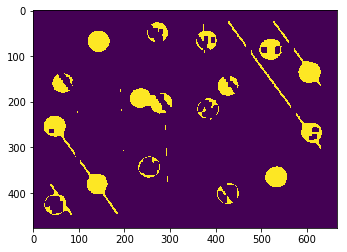

In [29]:
edges = cv2.Canny(img_hough_original, 100, 200)
for rho,theta in point_red + point_blue:
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))
    mid_x, mid_y = int((x1 + x2)/2),int((y1+y2)/2)
    try:
        cv2.line(edges,(x1,y1),(x2,y2),(0, 0, 0),5)
    except Exception as e:
        print(e)
        print(mid_x, mid_y)


kernel = np.ones((5,5),np.uint8)
dilation = cv2.dilate(edges, kernel,iterations = 2)
erosion = cv2.erode(dilation, kernel,iterations = 2)
show('bonus', erosion)

[[[0. 0. 0.]]]
Circle Detection


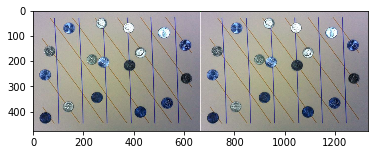

In [30]:
circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, 1.2, 150)
output = cv2.imread('original_imgs/hough.jpg')
print(circles)
if circles is not None:
    circles = np.round(circles[0, :]).astype("int")
     
    for (x, y, r) in circles:
        if r < 50:
            cv2.circle(output, (x, y), r, (0, 255, 0), 4)
    show('Circle Detection', np.hstack([img_hough_original, output]))